# Data Acquisition

In [1]:
import requests
import os
from dotenv import load_dotenv

In [2]:
from io import StringIO
import numpy as np
import pandas as pd

In [3]:
load_dotenv("./.env")

True

In [4]:
API_KEY = os.getenv("ALPHAVANTAGE_API_KEY")
FUNCTION = "TIME_SERIES_INTRADAY_EXTENDED"
INTERVAL = "60min" # 1min, 5min, 15min, 30min, or 60min

def query(name_of_equity, window):
    if window <= 12:
          y = 1
          m = window
    elif window<=24:
          y = 2
          m = window-12
    csv_url =  f"http://alphavantage.co/query?function={FUNCTION}&symbol={name_of_equity}"
    csv_url += f"&interval={INTERVAL}&slice=year{y}month{m}&apikey={API_KEY}"
    with requests.Session() as s:
            try:
                download = s.get(csv_url)
                decoded_content = download.content.decode('utf-8')
                data = StringIO(decoded_content)
                df = pd.read_csv(data, delimiter=",", parse_dates=["time"], index_col="time")
            except:
                print(f"Failed to Load year{y}month{m}")
                df = pd.DataFrame()
    return df

In [5]:
query("PTON",22)

,open,high,low,close,volume
time,,,,,
2020-09-02 20:00:00,89.1200,90.7700,89.0100,90.5000,29401
2020-09-02 19:00:00,89.3000,89.5900,89.0100,89.0100,16705
2020-09-02 18:00:00,90.0000,90.2500,89.4200,89.4200,22572
2020-09-02 17:00:00,91.0600,91.2000,88.7500,90.0000,103469
2020-09-02 16:00:00,90.5901,91.3692,89.7900,91.0500,2721164
...,...,...,...,...,...
2020-08-04 12:00:00,70.2250,70.3450,69.0900,69.9100,1072568
2020-08-04 11:00:00,70.7100,71.4000,70.1300,70.2250,937860
2020-08-04 10:00:00,71.7001,71.8400,69.4937,70.6973,1313707


In [6]:
import time
def get_data(name_of_equity):
    for i in range(24):
        print(i+1, end=" ")
        if i%5==4:
            time.sleep(90)
        if i==0:
            df = query(name_of_equity,i+1)
        else:
            df = pd.concat([df, query(name_of_equity,i+1)])
    df = df.sort_index()
    return df

In [7]:
df = get_data("TSLA")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [8]:
df.head()

,open,high,low,close,volume
time,,,,,
2022-05-25 20:00:00,657.25,657.90,654.32,655.30,39280
2022-05-25 19:00:00,653.50,657.50,653.01,657.50,47203
2022-05-25 18:00:00,649.33,658.80,649.33,653.50,117214
2022-05-25 17:00:00,658.63,658.81,640.00,648.75,648779
2022-05-25 16:00:00,663.34,669.32,657.00,658.68,3652460


# Preprocessing

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
def scale_data(df):
    # Dictionary to Store Data after Scaling
    scaled_data = {}
    
    # Dictionary to Store Column Transformers
    # (for easy inversion)
    scalers = {}
    
    for col in df.columns:
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data[col] = scaler.fit_transform(df[col].values.reshape(-1,1)).flatten()
        scalers[col] = scaler
    return pd.DataFrame.from_dict(scaled_data), scalers

def invert_scaling(data, feat_name):
    return scalers[feat_name].inverse_transform(data.reshape(-1,1))
        

In [11]:
df_scaled, scalers = scale_data(df)

In [12]:
df_scaled

,open,high,low,close,volume
0,0.451885,0.449245,0.453862,0.450170,0.001035
1,0.448375,0.448873,0.452626,0.452229,0.001244
2,0.444473,0.450082,0.449154,0.448485,0.003095
3,0.453176,0.450092,0.440352,0.444040,0.017149
4,0.457585,0.459868,0.456390,0.453333,0.096562
...,...,...,...,...,...
7936,0.000262,0.000650,0.000717,0.001235,0.014520
7937,0.000337,0.000000,0.000981,0.000000,0.003217
7938,0.000915,0.000435,0.001094,0.000112,0.000201
7939,0.000730,0.000435,0.001849,0.001046,0.000114


### Invert Scaling Test

In [134]:
feat = "close"

inverted_vector = invert_scaling(df_scaled[feat].values, feat)

test_df = pd.DataFrame(data=inverted_vector, index=df.index, columns=[f"{feat} (reverse scaled)"])
test_df[feat] = df[feat]

display(test_df)

,close (reverse scaled),close
time,,
2020-06-05 05:00:00,175.412,175.412
2020-06-05 06:00:00,175.398,175.398
2020-06-05 07:00:00,174.400,174.400
2020-06-05 08:00:00,174.280,174.280
2020-06-05 09:00:00,175.600,175.600
...,...,...
2022-05-25 16:00:00,658.680,658.680
2022-05-25 17:00:00,648.750,648.750
2022-05-25 18:00:00,653.500,653.500


# Sequence Data

In [14]:
def create_dataset(data,
                   target_feat,
                   look_back,
                   look_ahead):
    n_samples = data.shape[0]
    window_length = look_back + look_ahead
    n_seq = (n_samples - window_length + 1)
    
    # Separate Data into target and feature numpy arrays
    y_data = data[target_feat].to_numpy()
    x_data = data.to_numpy()
       
    for i in range(n_seq):
        
        # create an input sequence sample
        x = x_data[i:i+look_back].reshape(1,look_back,x_data.shape[1])
        
        # create an output sequence sample
        y = y_data[i+look_back:i+window_length].reshape(1,-1)
        
        if i==0:
            X = x
            Y = y
        else:
            X = np.vstack((X,x))
            Y = np.vstack((Y,y))

    return X, Y
    

In [15]:
target = "close"
look_back = 11*24 # 11 Days (in hours)
look_ahead = 4*24 # 4 days (in hours)

X, Y = create_dataset(df_scaled,target,look_back,look_ahead)

print(X.shape, Y.shape)

(7582, 264, 5) (7582, 96)


# Train-Test Split

In [16]:
def train_test_split(X,
                     Y,
                     train_size):
    n_seq = X.shape[0]
    train_size = int(n_seq*train_size)
    X_train, Y_train = X[:train_size,:], Y[:train_size,:]
    X_test, Y_test = X[train_size:,:], Y[train_size:,:]
    
    return X_train, Y_train, X_test, Y_test

In [17]:
X_train, Y_train, X_test, Y_test = train_test_split(X,Y,0.8)
print("Training: ", X_train.shape, Y_train.shape)
print("Testing: ", X_test.shape, Y_test.shape)

Training:  (6065, 264, 5) (6065, 96)
Testing:  (1517, 264, 5) (1517, 96)


# Neural Network

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, BatchNormalization, AveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
def build_model(# General Hyperparameters
                optimizer="adam",
                learning_rate=0.0005,
                p_drop=0.25,
                # Convolution Hyperparamemters
                convolution_activation="tanh",
                convolution_padding="same",
                convolution_filters=128,
                convolution_kernel=6,
                convolution_strides=2,
                pooling_size=6,
                pooling_strides=2,
                # LSTM Hyperparameters
                n_lstm_layers=3,
                lstm_activation="relu",
                # Dense Hyperparameters
                dense_activation="relu"
               ):
    
    # Input Shape
    # X_train.shape = (n_seq_samples, look_back, n_features)
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Optimizer
    
    if optimizer == "adam":
        opt = Nadam(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)
    
    # Functional Keras Model ************
    
    # Input Layer
    inputs = Input(shape=input_shape)
    
    # Conv1D Layer
    x = Conv1D(
        filters=convolution_filters,
        kernel_size=convolution_kernel,
        strides=convolution_strides,
        padding=convolution_padding,
        activation=convolution_activation
    )(inputs)
    # x = BatchNormalization()(x)
    x = AveragePooling1D(
        pool_size = pooling_size,
        strides = pooling_strides
    )(x)
    x = Dropout(p_drop)(x)
    
    # LSTM Layers
    return_seq = True
    for i in range(n_lstm_layers):
        if i==n_lstm_layers-1:
            return_seq = False
        x = LSTM(128,
                activation=lstm_activation,
                return_sequences=return_seq)(x)
        # x = BatchNormalization()(x)
        
    x = Dropout(p_drop)(x)


    # Dense Layer
    x = Dense(128,
              activation=dense_activation)(x)
    # x = BatchNormalization()(x)
    x = Dropout(p_drop)(x)
    
    # Output Layer
    outputs = Dense(look_ahead,
                    activation='relu')(x)
    
    model = Model(inputs=inputs,
                  outputs=outputs)
    
    model.compile(
        loss='mean_absolute_error',
        optimizer=opt
        ,metrics = ['mean_squared_error']
    )
    
    return model

In [84]:
model = build_model(optimizer="nadam")

In [85]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 264, 5)]          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 132, 128)          3968      
                                                                 
 average_pooling1d_4 (Averag  (None, 64, 128)          0         
 ePooling1D)                                                     
                                                                 
 dropout_12 (Dropout)        (None, 64, 128)           0         
                                                                 
 lstm_12 (LSTM)              (None, 64, 128)           131584    
                                                                 
 lstm_13 (LSTM)              (None, 64, 128)           131584    
                                                           

In [104]:
stop = EarlyStopping(
            monitor = "val_mean_squared_error",
            min_delta = 0.0001,
            baseline = 0.01,
            patience = 20,
            restore_best_weights=True
        )

In [87]:
def fit_model(model,
              epochs=1000,
              batch_size=128):
    
    history = model.fit(
        X_train,
        Y_train,
        epochs = epochs,
        batch_size = batch_size,
        verbose = 2,
        workers = 1,
        validation_data = (X_test, Y_test),
        callbacks=[stop]
    )
    
    return history

In [88]:
history = fit_model(model)

Epoch 1/1000
48/48 - 27s - loss: 0.0801 - mean_squared_error: 0.1573 - val_loss: 0.0052 - val_mean_squared_error: 0.0069 - 27s/epoch - 559ms/step
Epoch 2/1000
48/48 - 21s - loss: 0.0126 - mean_squared_error: 0.0314 - val_loss: 0.0037 - val_mean_squared_error: 0.0047 - 21s/epoch - 431ms/step
Epoch 3/1000
48/48 - 20s - loss: 0.0076 - mean_squared_error: 0.0197 - val_loss: 0.0032 - val_mean_squared_error: 0.0041 - 20s/epoch - 424ms/step
Epoch 4/1000
48/48 - 21s - loss: 0.0057 - mean_squared_error: 0.0152 - val_loss: 0.0031 - val_mean_squared_error: 0.0038 - 21s/epoch - 428ms/step
Epoch 5/1000
48/48 - 22s - loss: 0.0048 - mean_squared_error: 0.0129 - val_loss: 0.0041 - val_mean_squared_error: 0.0052 - 22s/epoch - 459ms/step
Epoch 6/1000
48/48 - 25s - loss: 0.0042 - mean_squared_error: 0.0112 - val_loss: 0.0055 - val_mean_squared_error: 0.0069 - 25s/epoch - 516ms/step
Epoch 7/1000
48/48 - 24s - loss: 0.0038 - mean_squared_error: 0.0101 - val_loss: 0.0071 - val_mean_squared_error: 0.0092 - 2

# Model Predictions

In [89]:
import matplotlib.pyplot as plt

In [90]:
def predict(X, model):
    return invert_scaling(data=model.predict(X),
                          feat_name=target)

In [91]:
X_train.shape

(6065, 264, 5)

In [92]:
y_train_pred = predict(X_train, model)
y_train_actual = invert_scaling(data=Y_train,
                                feat_name=target)
y_test_pred = predict(X_test, model)
y_test_actual = invert_scaling(Y_test,
                                feat_name=target)

48/48 [==============================] - 4s 83ms/step


In [93]:
X_train.shape, X_test.shape

((6065, 264, 5), (1517, 264, 5))

In [94]:
Y_train.shape, Y_test.shape

((6065, 96), (1517, 96))

In [119]:
def format_train_test_predictions(model):

    # Get Predictions for Both Datasets
    y_train_pred = predict(X_train, model)
    y_train_actual = invert_scaling(data=Y_train,
                                    feat_name=target)
    y_test_pred = predict(X_test, model)
    y_test_actual = invert_scaling(Y_test,
                                    feat_name=target)

    # Each prediction is for 4 days (in hours)
    # but we used every hour as a different starting point for our sequences
    # so our prediction windows overlap
    # This can be fixed below by taking the i_th day and j_th hour prediction
    # from each 4 day prediction window
    # To make this process easy, the data is reshaped into 
    # (n_sequences, day_ahead_predicted, hour_of_that_day_predicted)

    train_size = X_train.shape[0]
    test_size = X_test.shape[0]

    y_train_pred = y_train_pred.reshape(train_size, look_ahead//24, 24, order='C')
    y_test_pred = y_test_pred.reshape(test_size, look_ahead//24, 24, order='C')

    y_train_actual = y_train_actual.reshape(train_size, look_ahead//24, 24, order='C')
    y_test_actual = y_test_actual.reshape(test_size,look_ahead//24, 24, order='C')

    return y_train_pred, y_train_actual, y_test_pred, y_test_actual

In [120]:
y_train_pred, y_train_actual, y_test_pred, y_test_actual = format_train_test_predictions(model)

48/48 [==============================] - 2s 40ms/step


In [121]:
y_train_pred.shape, y_test_pred.shape

((6065, 4, 24), (1517, 4, 24))

In [122]:
y_train_actual.shape, y_test_actual.shape

((6065, 4, 24), (1517, 4, 24))

In [102]:
print("**Training Set**")
sample = np.random.randint(low=0,high=X_train.shape[0])
print("Predictions: ", y_train_pred[sample,:].shape)
print("Actual: ", y_train_actual[sample,:].shape)
print()

print("**Testing Set**")
sample = np.random.randint(low=0,high=X_test.shape[0])
print("Predictions: ", y_test_pred[sample,:].shape)
print("Actual: ", y_test_actual[sample,:].shape)

**Training Set**
Predictions:  (4, 24)
Actual:  (4, 24)

**Testing Set**
Predictions:  (4, 24)
Actual:  (4, 24)


In [128]:
def plot_predictions(days_ahead, hour_in_day, y_train_pred, y_train_actual, y_test_pred, y_test_actual):

    plt.figure(figsize=(20,5))
    plt.title("Training Set: True vs Predicted")
    plt.grid()
    plt.plot(y_train_pred[:,days_ahead-1,hour_in_day-1], label = "Predict", c="r")
    plt.plot(y_train_actual[:,days_ahead-1,hour_in_day-1], label= "True", c="c")
    plt.legend();

    plt.figure(figsize=(20,5))
    plt.title("Test Set: True vs Predicted")
    plt.grid()
    plt.plot(y_test_pred[:,days_ahead-1,hour_in_day-1], label = "Predict", c="r")
    plt.plot(y_test_actual[:,days_ahead-1,hour_in_day-1], label= "True", c="c")
    plt.legend();

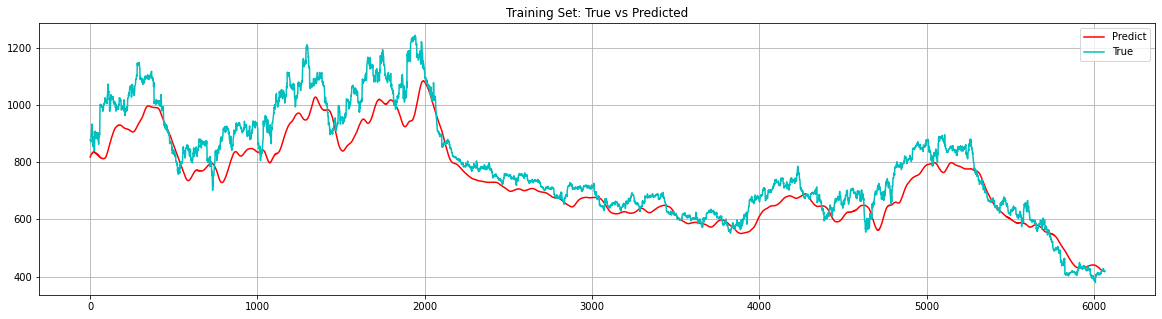

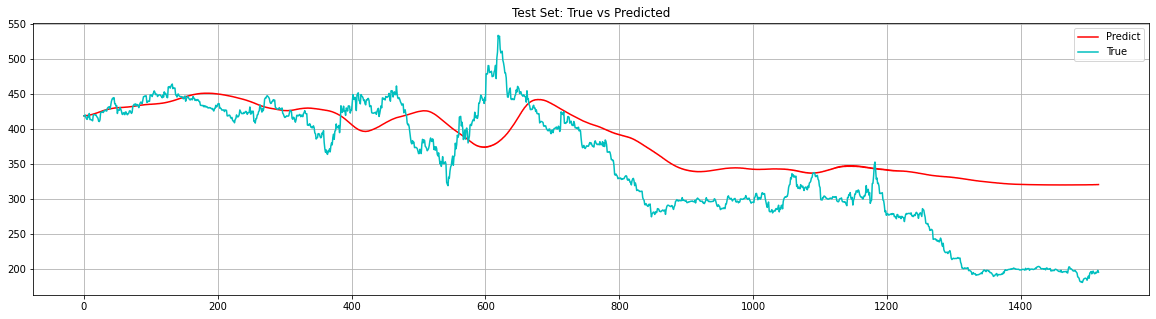

In [100]:
plot_predictions(1, 24, y_train_pred, y_train_actual, y_test_pred, y_test_actual)

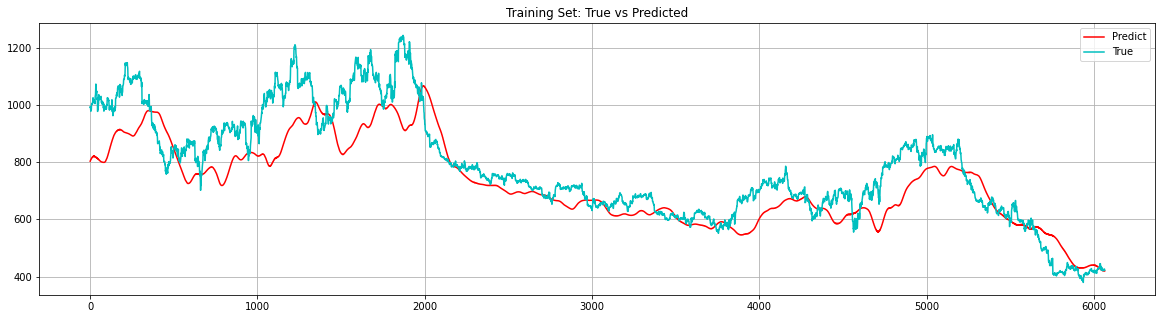

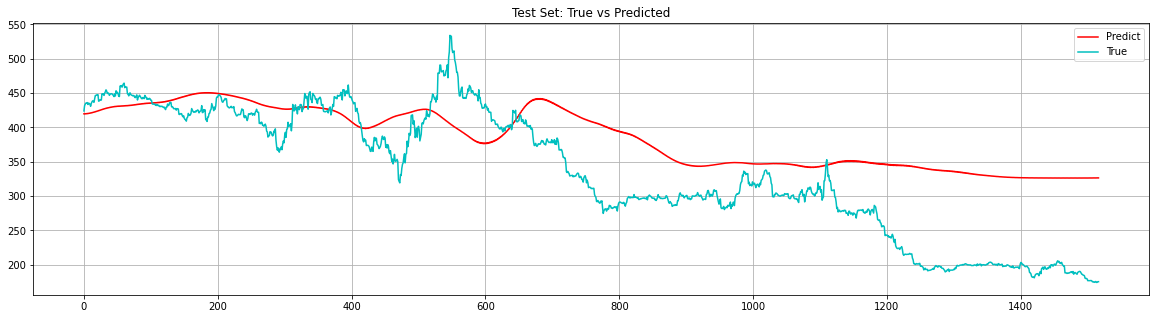

In [101]:
plot_predictions(4, y_train_pred, y_train_actual, y_test_pred, y_test_actual)

In [79]:
def plot_model_loss_metrics(history):
        
        # plot training and test loss scores 
        test_loss = history.history["val_loss"]
        train_loss = history.history["loss"]
        
        n_epochs = len(test_loss) + 1
        epochs = np.arange(1,  n_epochs)

        plt.figure(figsize=(20,8))
        plt.title("Loss vs. Number of Epochs")
        plt.plot(epochs[1:], test_loss[1:], label = "Test Loss")
        plt.plot(epochs[1:], train_loss[1:], label = "Train Loss")
        plt.xticks(epochs[1:])
        plt.ylim((0,0.2))
        plt.grid()
        plt.legend()
        plt.show() 

        return

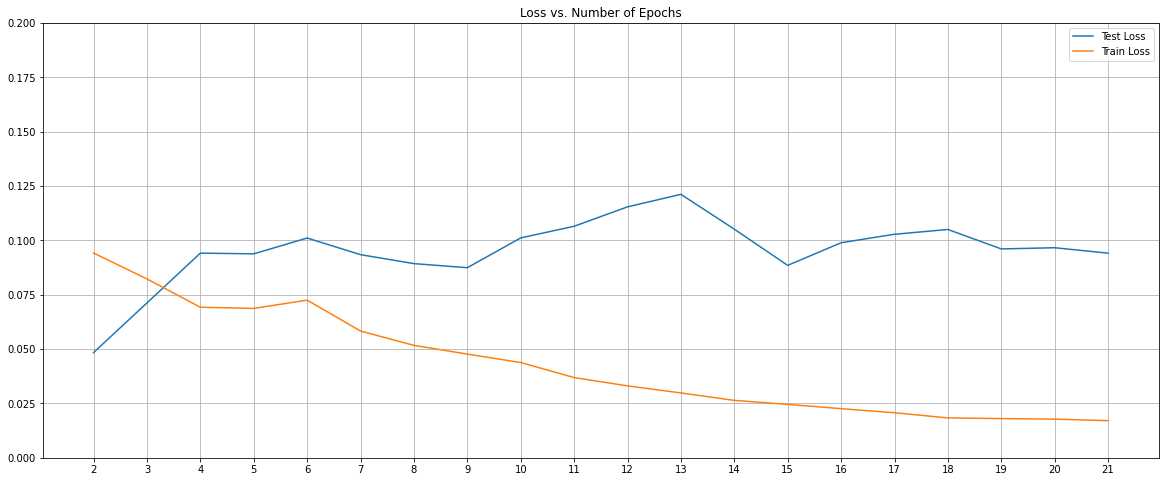

In [80]:
plot_model_loss_metrics(history)

In [105]:
model.evaluate(X_test, Y_test)

48/48 [==============================] - 4s 75ms/step - loss: 0.0031 - mean_squared_error: 0.0038


[0.0030563033651560545, 0.003804501611739397]

In [81]:
# !ls
# os.mkdir('models')

In [103]:
model_name = "model0"
model.save(f"models/{model_name}")

INFO:tensorflow:Assets written to: models/model0/assets


INFO:tensorflow:Assets written to: models/model0/assets


# Hyperparameter Tuning

In [107]:
from keras_tuner.tuners import Hyperband
from keras_tuner import HyperParameters
from tensorflow.keras.layers import BatchNormalization, MaxPool1D

In [109]:
def build_better_model(hyper_parameters):

    # General Hyperparameters
    optimizer = hyper_parameters.Choice(name="optimizer", values=["adam", "nadam"])
    learning_rate = hyper_parameters.Float(name="learning_rate", min_value=0.0001, max_value=0.01, sampling="log")
    p_drop = hyper_parameters.Float(name="dropout_probability", min_value=0.10, max_value=0.40, step=0.05)
    batch_normalization = hyper_parameters.Choice(name="batch_normalization", values=[True, False])

    # 1D Convolution
    convolution_filters = 2**hyper_parameters.Int(name="conv_filter_power", min_value=6, max_value=9)
    convolution_kernel = hyper_parameters.Int(name="conv_kernel_size", min_value=6, max_value=12)
    convolution_strides = hyper_parameters.Int(name="convolution_strides", min_value=2, max_value=6)
    convolution_padding = hyper_parameters.Choice(name="conv_padding_strat", values=["valid", "causal", "same"])
    convolution_activation = hyper_parameters.Choice(name="conv_activation", values=["tanh", "relu", "selu"])
    pooling_strategy = hyper_parameters.Choice(name="pooling_strategy", values=["avg", "max"])
    pooling_size = hyper_parameters.Int(name="pooling_size", min_value=6, max_value=12)
    pooling_strides = hyper_parameters.Int(name="pooling_strides", min_value=2, max_value=6)

    # LSTM
    n_lstm_layers = hyper_parameters.Int(name="n_lstm_layers", min_value=3, max_value=5)
    lstm_units = 2**hyper_parameters.Int(name="lstm_unit_power", min_value=4, max_value=8)
    lstm_activation = hyper_parameters.Choice(name="lstm_activation", values=["relu", "tanh", "selu"])

    # Dense
    dense_units = 2**hyper_parameters.Int(name="dense_unit_power", min_value=4, max_value=8)
    dense_activation = hyper_parameters.Choice(name="conv_activation", values=["relu", "selu"])
    
    # Input Shape
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Optimizer
    if optimizer == "nadam":
        opt = Nadam(learning_rate=learning_rate)
    elif optimizer == "adam":
        opt = Adam(learning_rate=learning_rate)
    
    
    # Input ***********************************
    inputs = Input(shape=input_shape)
    # *****************************************
    
    # Conv1D **********************************
    x = Conv1D(
        filters=convolution_filters,
        kernel_size=convolution_kernel,
        strides=convolution_strides,
        padding=convolution_padding,
        activation=convolution_activation
    )(inputs)
    # Pooling
    if pooling_strategy == "avg":
        x = AveragePooling1D(
            pool_size = pooling_size,
            strides = pooling_strides
        )(x)
    elif pooling_strategy == "max":
        x = MaxPool1D(
            pool_size = pooling_size,
            strides = pooling_strides
        )(x)
    # Batch Normalization
    if batch_normalization:
        x = BatchNormalization()(x)
    # Drop Out
    x = Dropout(p_drop)(x)
    # *****************************************
    
    # LSTM ************************************
    return_seq = True
    for i in range(n_lstm_layers):
        if i==n_lstm_layers-1:
            return_seq = False
        x = LSTM(lstm_units,
                activation=lstm_activation,
                return_sequences=return_seq)(x)
        # Batch Normalization
        if batch_normalization:
            x = BatchNormalization()(x)
    # Drop Out
    x = Dropout(p_drop)(x)
    # ******************************************

    # Dense ************************************
    x = Dense(dense_units,
              activation=dense_activation)(x)
    # Batch Normalization
    if batch_normalization:
        x = BatchNormalization()(x)
    # Drop Out
    x = Dropout(p_drop)(x)
    # ******************************************

    # Output Layer *****************************
    outputs = Dense(look_ahead,
                    activation='relu')(x)
    # ******************************************
    
    model = Model(inputs=inputs,
                  outputs=outputs)
    
    model.compile(
        loss='mean_squared_logarithmic_error',
        optimizer=opt,
        metrics=["mean_squared_error"]
    )
    
    return model

In [110]:
tuner = Hyperband(
    build_better_model,
    objective="val_mean_squared_error",
    max_epochs=75,
    hyperband_iterations=1,
    directory='hyper_tuners',
    project_name="tuner0",
    overwrite=True
)

In [111]:
tuner.search(
    X_train,
    Y_train,
    batch_size=128,
    validation_data = (X_test, Y_test),
    callbacks=[stop]
)

Trial 90 Complete [00h 05m 00s]
val_mean_squared_error: 0.01086430437862873

Best val_mean_squared_error So Far: 0.0014158400008454919
Total elapsed time: 02h 40m 44s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [112]:
n_best_models = 3

models = tuner.get_best_models(num_models=n_best_models)
for i in range(n_best_models):
    hypertuned_model = models[i]
    model_name = f"tuned_model{i+1}"
    hypertuned_model.save(f"models/{model_name}")

INFO:tensorflow:Assets written to: models/tuned_model1/assets


INFO:tensorflow:Assets written to: models/tuned_model1/assets


INFO:tensorflow:Assets written to: models/tuned_model2/assets


INFO:tensorflow:Assets written to: models/tuned_model2/assets


INFO:tensorflow:Assets written to: models/tuned_model3/assets


INFO:tensorflow:Assets written to: models/tuned_model3/assets


In [114]:
import tensorflow

In [115]:
best_model = tensorflow.keras.models.load_model('models/tuned_model1')

In [132]:
best_model.evaluate(X_test, Y_test)

48/48 [==============================] - 2s 29ms/step - loss: 0.0010 - mean_squared_error: 0.0014


[0.001031706458888948, 0.00141583988443017]

In [123]:
y_train_pred, y_train_actual, y_test_pred, y_test_actual = format_train_test_predictions(best_model)

48/48 [==============================] - 1s 22ms/step


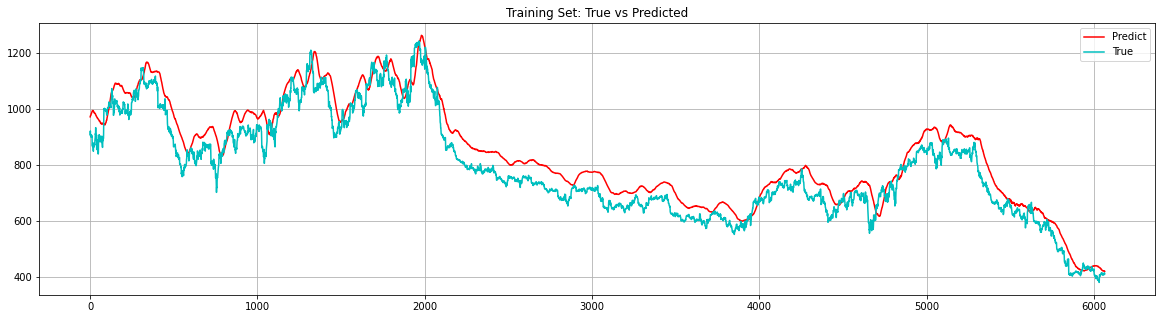

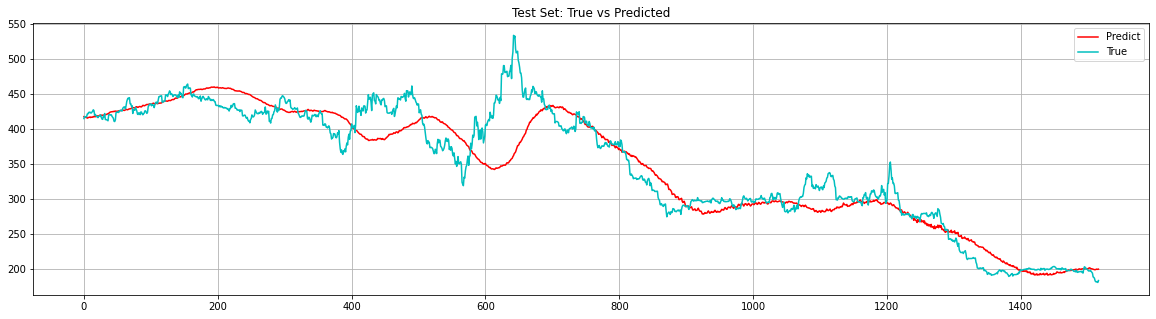

In [131]:
plot_predictions(1, 1, y_train_pred, y_train_actual, y_test_pred, y_test_actual)

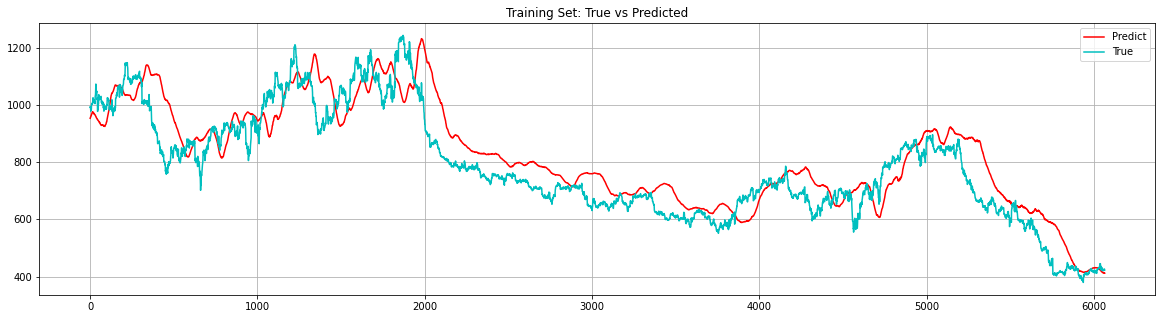

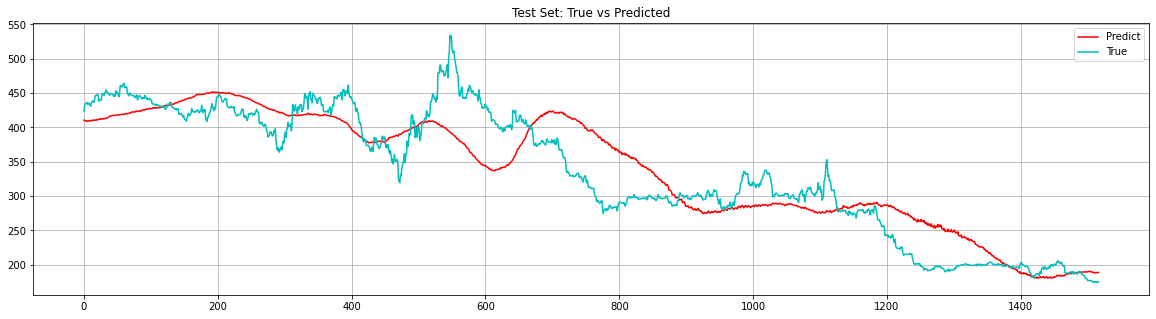

In [129]:
plot_predictions(4, 24, y_train_pred, y_train_actual, y_test_pred, y_test_actual)